In [1]:
import kagglehub 

path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")

print(f"Path to dataset files,{path}")

100%|██████████| 276k/276k [00:00<00:00, 20.0MB/s]

Extracting files...
Path to dataset files,C:\Users\18126\.cache\kagglehub\datasets\sbhatti\financial-sentiment-analysis\versions\4


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\18126\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\18126\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\18126\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 256/256 [26:44<00:00,  6.27s/it]


Average loss: 0.7061


Epoch 2: 100%|██████████| 256/256 [27:48<00:00,  6.52s/it]


Average loss: 0.3743


Epoch 3: 100%|██████████| 256/256 [28:30<00:00,  6.68s/it]


Average loss: 0.2699
BERT Model Performance:
              precision    recall  f1-score   support

    positive       0.50      0.76      0.60       258
    negative       0.91      0.73      0.81       939
     neutral       0.81      0.89      0.85       556

    accuracy                           0.78      1753
   macro avg       0.74      0.79      0.75      1753
weighted avg       0.82      0.78      0.79      1753



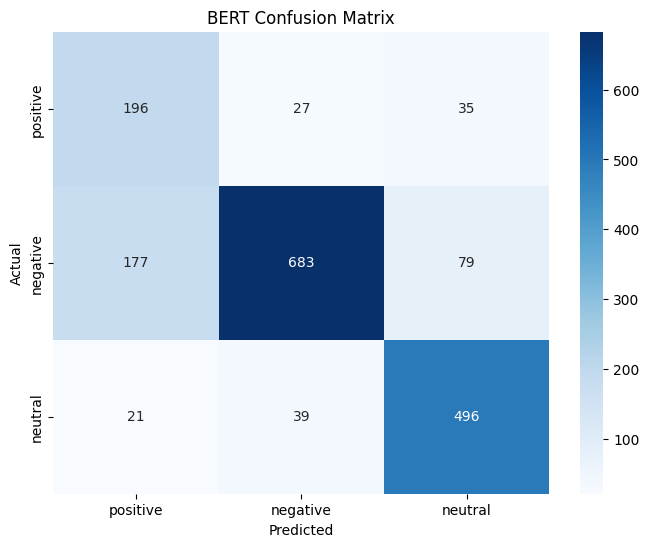

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Load and preprocess data
df = pd.read_csv(r"C:\Users\18126\.cache\kagglehub\datasets\sbhatti\financial-sentiment-analysis\versions\4\data.csv")
texts = df['Sentence'].values
labels = pd.Categorical(df['Sentiment']).codes

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

# BERT implementation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# We can summon BERT now
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3
)

# Let' calculate class weights for imbalance
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float)

# We can set the training to our GPU if we have one
BATCH_SIZE = 16
EPOCHS = 3
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss(weight=class_weights.to(device))

# Let's train our model, this might take a while (depending on the GPU, I'm working on an RTX 3060) 
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
    
    print(f"Average loss: {total_loss / len(train_loader):.4f}")

# Let's evaluate our model
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Metrics
print("BERT Model Performance:")
print(classification_report(y_true, y_pred, target_names=df['Sentiment'].unique()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df['Sentiment'].unique(), 
            yticklabels=df['Sentiment'].unique())
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


BERT had a better result as it contains transformers, compared to bag-of-words from TFIDF. BERT also contains contextual embeddings and it is a pre-trained language model, that we specifically fine-tuned on financial text. Some other reasons I can think of that explain the performance difference are the following:

Sarcasm handling: This means that BERT classified phrases like "wouldn't be surprised this is bullish" as positive, not as neutral.
Pre-trained parameters: BERT contains over 110M parameters of pretrained knowledge, so it is safe to use it has a small advantage compared to training the sklearn model from scratch. 
Attention: We know that it is everything a model needs (just kidding ... kind of). Jokes aside, having context is very important in classifying sentiment as a piece of text might refer to a ticker stock value, an earnings presentation, or the Company as a whole.

Although it might look like BERT is simply better at everything compared to a more basic model, there are definitely some trade offs we should probably consider. 

Training speed:  The BERT-based code took me ~90 minutes to run; whereas the sklearn model took less than 2 minutes. This is a big difference
Hardware needed: One needs a GPU to make use of fine tuning BERT. Here is a the set of my laptop's relevant specs (CPU: quad-core core i7 11th Gen, , GPU: NVIDIA Geforce RTX 3060).
Explainability: I am more able to describe the performance of the TFIDF model than the one from BERT as it has millions of parameters. A pre-trained model is a bit more unknown than one that we have trained from scratch as the logistic regression has coefficients, which we can explain more easily.